## 2. Oil Field Example: Total Thickness of Two Formations

Your company is about to drill into two formations: formation A and formation B. From the previous experiences within the asset, you know the the distribution of each formation's thickness (which is rarely the case...). In order to develop production / facility plans, you need to draw an uncertainty model for the total thickness of formation A + formation B

## 2.0.1 Assumptions

Before Monte-Carlo simulation is run to develop the uncertainty model, a few assumptions will be made.

* The formation thickness in the asset has Gaussian distribution
* Formation A has a mean value of 10 ft, and standard deviation of 2 ft.
* Formation B has a mean value of 24 ft, and standard deviation of 4 ft.
* The mean and standard deviation were calculated from large enough samples, and their values are reliable.
* We are not given any sample data set. We are only given mean and standard deviations.

### Import to Libraries

In [1]:
import random
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib notebook

In [2]:
assumptions = pd.DataFrame(data=[[10, 24],[2, 4]], columns=['Formation A (ft)', 'Formation B (ft)'], index=['mean', 'stdev'])
assumptions

,Formation A (ft),Formation B (ft)
mean,10,24
stdev,2,4


Recall that Monte-Carlo simulation requires the distribution shape and distribution parameters of the population. If we know the distribution shape, but do not have large enough samples to estimate reasonable values for the mean and the standard deviation of the population, Monte-Carlo simulation for Gaussian distribution may return inaccurate results. This can't really be helped since we just don't have enough samples.

Furthermore, if we have reasonably large enough samples, but do not know the distribution shape, **Monte-Carlo simulation** cannot be run. Recall that when generating random samples, it assumes a certain form of a distribution. `(Ex: numpy.random.normal(), numpy.random.lognormal(), numpy.random.chiquare()).`

**Notes**

If Monte-Carlo simulation cannot be run because the distribution shape is unknown, non-parametric Bootstrap simulation can be used to generate random samples.

## 2.0.2 Why Use Monte-Carlo Simulation?

One might ask why Monte-Carlo simulation is needed for this task. Why can't we just add the provided means of the two formations and use it for our thickness model?

$$TotalThickness = Form. A Mean Thickness + Form. B Mean Thickness$$

$$Total Thickness = 10 ft + 24 ft = 34 ft$$

However, this simple forecast model does not give any information about the uncertainty in the total thickness of the formation. That is, we only know the overall mean thickness, but nothing about the possible range of thickness of the formations. Ideally we want to formulate something like the following:
`The total formation thickness will fall within the range of 27 ~ 41 ft by 80% chance, with 34 ft being the mean of the distribution.`
When we are given only the estimated mean and standard deviation of the population, uncertainty model cannot be formulated without some kind of random sampling method. Monte-Carlo simulation can be used to generate a pool of random samples.

## 2.1 Monte-Carlo Simulation for Gaussian Distribution

**Steps**

* Using the provided mean and standard deviation, generate a random Gaussian distribution of Formation A and B thickness. Recall that we assumed the thickness distribution to be Gaussian. Generate random thickness values N times.
* Add the randomly generated thickness values for Formation A and B.
* Generate visualizations (CDF, boxplot, etc...)
The distribution is Gaussian, and therefore `np.random.normal()` will be used to generate random normal distribution of formation thickness. If the distribution was assumed to be non-Gaussian, other function will be used to create random samples. For more information, check the numpy documentation of `random sampling for various distributions.`

In [3]:
mean_A = assumptions['Formation A (ft)']['mean']
mean_B = assumptions['Formation B (ft)']['mean']
std_A = assumptions['Formation A (ft)']['stdev']
std_B = assumptions['Formation B (ft)']['stdev']

iteration = 1000

monte_A = np.random.normal(mean_A, std_A, iteration)   
monte_B = np.random.normal(mean_B, std_B, iteration)
total_thic = monte_A + monte_B

df_thic = pd.DataFrame([monte_A, monte_B, total_thic], index=['Formation A (ft)', 'Formation B (ft)', 'Total Thickness (ft)']).T
df_thic.index.name = 'Iteration'
df_thic.round(1).head(10)

,Formation A (ft),Formation B (ft),Total Thickness (ft)
Iteration,,,
0,8.6,18.9,27.5
1,6.5,23.2,29.8
2,8.1,23.5,31.6
3,11.5,19.0,30.4
4,8.0,24.8,32.8
5,14.1,30.0,44.1
6,9.9,26.7,36.7
7,9.8,22.3,32.1
8,9.6,28.8,38.4


## Visualizations

Cumulative probablity function (CDF) and boxplot can be used to visualize the simulation result.

In [4]:
def visualize_distribution(dataframe, ax_):
    dataframe = dataframe.apply(lambda x: x.sort_values().values)
    
    for col, label in zip(dataframe, dataframe.columns):
        fit = scipy.stats.norm.pdf(dataframe[col], np.mean(dataframe[col]), np.std(dataframe[col]))
        ax_.plot(dataframe[col], fit)
    ax_.set_ylabel('Probability')

<IPython.core.display.Javascript object>


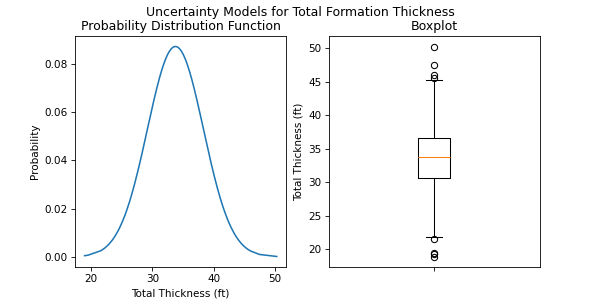

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Uncertainty Models for Total Formation Thickness')

visualize_distribution(df_thic['Total Thickness (ft)'].to_frame(), ax1)
ax1.set_title('Probability Distribution Function')
ax1.set_ylabel('Probability')
ax1.set_xlabel('Total Thickness (ft)')

ax2.boxplot(df_thic['Total Thickness (ft)'])
ax2.set_title('Boxplot')
ax2.set_ylabel('Total Thickness (ft)');
ax2.set_xticklabels([]);

## Business Decision on P10, P50, and P90 Statistics
Many of the business decisions are made on P10, P50, and P90 values. When reporting your statistical analysis to the management, you want to provide them the most likely range of outcome.

In [6]:
pd.DataFrame(df_thic['Total Thickness (ft)'].describe(percentiles=[0.1, 0.9])).T.iloc[:, 4:7].round(1)


,10%,50%,90%
Total Thickness (ft),28.2,33.7,39.7


Based on the obtained P10, P50, and P90 values, the following forecast can be constructed:
`The total formation thickness will fall within the range of 28.6 ~ 39.9 ft by 80% chance, with 34.2 ft being the mean of the distribution.`